# 2D cross-well tomography


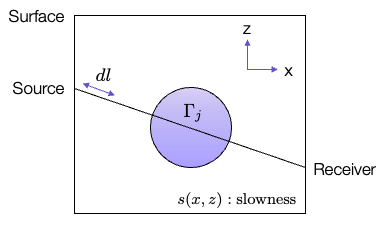

The forward simulation takes the form 

$$
t_j = \int_{\Gamma_j} s(x, y) dl
$$


where $s(x,y) = 1/v(x, y)$ is the slowness (equal to the inverse of the velocity). Note that we will work with $x$ as the first dimension and $y$ as the second dimension. 

In [38]:
import numpy as np
import matplotlib.pyplot as plt

import discretize

from SimPEG import seismic

from SimPEG import (
    maps,
    utils,
    survey,
    data,
    data_misfit,
    directives,
    optimization,
    regularization,
    inverse_problem,
    inversion,
)

## set up a mesh 

In [39]:
extent_x = 200 
extent_y = 400

dx = 10
dy = 10

In [40]:
nx = int(np.ceil(extent_x / dx))
ny = int(np.ceil(extent_y / dy))

hx = np.ones(nx) * dx
hy = np.ones(ny) * dy


In [41]:
mesh = discretize.TensorMesh([hx, hy])
mesh

TensorMesh: 800 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     20          0.00        200.00     10.00     10.00    1.00
   y     40          0.00        400.00     10.00     10.00    1.00

In [42]:
n_src = 10
y_src = np.linspace(dy/2, extent_y-dy/2, n_src)

source_locations = np.c_[np.zeros_like(y_src), y_src]
receiver_locations = np.c_[np.zeros_like(y_src) + mesh.nodes_x[-1], y_src]

In [43]:
source_locations

array([[  0.        ,   5.        ],
       [  0.        ,  48.33333333],
       [  0.        ,  91.66666667],
       [  0.        , 135.        ],
       [  0.        , 178.33333333],
       [  0.        , 221.66666667],
       [  0.        , 265.        ],
       [  0.        , 308.33333333],
       [  0.        , 351.66666667],
       [  0.        , 395.        ]])

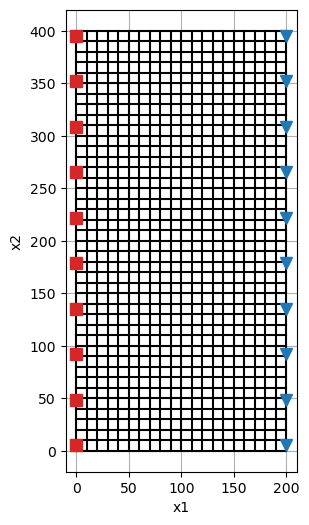

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))

mesh.plot_grid(ax=ax, color="k")
ax.set_aspect(1)

ax.plot(source_locations[:, 0], source_locations[:, 1], "C3s", ms=8)
ax.plot(receiver_locations[:, 0], receiver_locations[:, 1], "C0v", ms=8)


## build model

In [45]:
v0 = 1000
v1 = 2000
block_x = np.r_[60, 140]
block_y = np.r_[180, 220]

velocity_model = v0*np.ones(mesh.n_cells)
background_velocity = velocity_model.copy()

In [46]:
def add_block(velocity_model, block_x, block_y, value): 
    inds_block = (
        (mesh.cell_centers[:, 0] > block_x.min()) &
        (mesh.cell_centers[:, 0] < block_x.max()) &
        (mesh.cell_centers[:, 1] > block_y.min()) &
        (mesh.cell_centers[:, 1] < block_y.max()) 
    ) 

    velocity_model[inds_block] = value
    
    return velocity_model
    
velocity_model = add_block(velocity_model, block_x, block_y, v1) 

true_slowness_model = 1/velocity_model
background_slowness_model = 1/background_velocity

In [47]:
def plot_model_survey(
    mesh, model, source_locations, receiver_locations, ax=None, 
    show_raypaths=True, vmin=None, vmax=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1)
    
    cb = plt.colorbar(
        mesh.plot_image(model, ax=ax, pcolor_opts={"vmin":vmin, "vmax":vmax})[0], 
        ax=ax
    )
    
    cb.set_label("velocity (m/s)")
    
    ax.set_aspect(1)

    ax.plot(source_locations[:, 0], source_locations[:, 1], "ws", ms=6)
    ax.plot(receiver_locations[:, 0], receiver_locations[:, 1], "wv", ms=6)
    
    if show_raypaths is True: 
        for i in range(source_locations.shape[0]):
            for j in range(receiver_locations.shape[0]):
                ax.plot(
                    np.r_[source_locations[i, 0], receiver_locations[j, 0]],
                    np.r_[source_locations[i, 1], receiver_locations[j, 1]],
                    color="w",
                    linewidth=0.5
                )
    return ax



<AxesSubplot: xlabel='x', ylabel='y'>

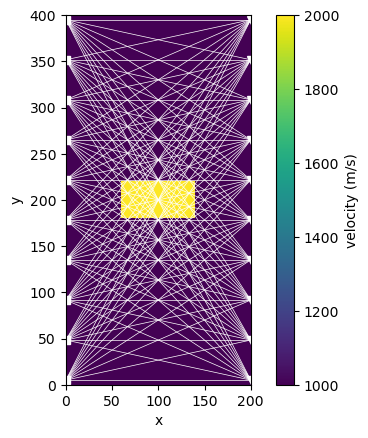

In [48]:
plot_model_survey(
    mesh, velocity_model, source_locations, receiver_locations,
    show_raypaths=True
)

## create a survey and simulation

In [49]:
rx = survey.BaseRx(receiver_locations)

# source_list = [
#     survey.BaseSrc(
#         location=source_locations[i, :], receiver_list=[rx]
#     )
#     for i in range(y_src.size)
# ]


source_list = []

for i in range(y_src.size):
    source_list.append(
        survey.BaseSrc(
            location=source_locations[i, :], receiver_list=[rx]
        )
    )

In [50]:
tomo_survey = seismic.straight_ray_tomography.Survey(source_list)

In [51]:
simulation = seismic.straight_ray_tomography.Simulation(
    mesh=mesh,
    survey=tomo_survey,
    slownessMap=maps.IdentityMap(mesh),
)

## simulate data

In [52]:
background_data = simulation.dpred(background_slowness_model)
clean_data = simulation.dpred(true_slowness_model)

In [53]:
relative_error=0.02
np.random.seed(1)

noisy_data = (
    clean_data + 
    np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)
)
background_noisy_data = (
    background_data + 
    np.random.randn(len(clean_data)) * relative_error * np.abs(background_data)
)

## plot the simulated data

In [54]:
levels = np.linspace(0.10, 0.50, 21)
contours = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

Text(0.5, 1.0, '(b) observed data')

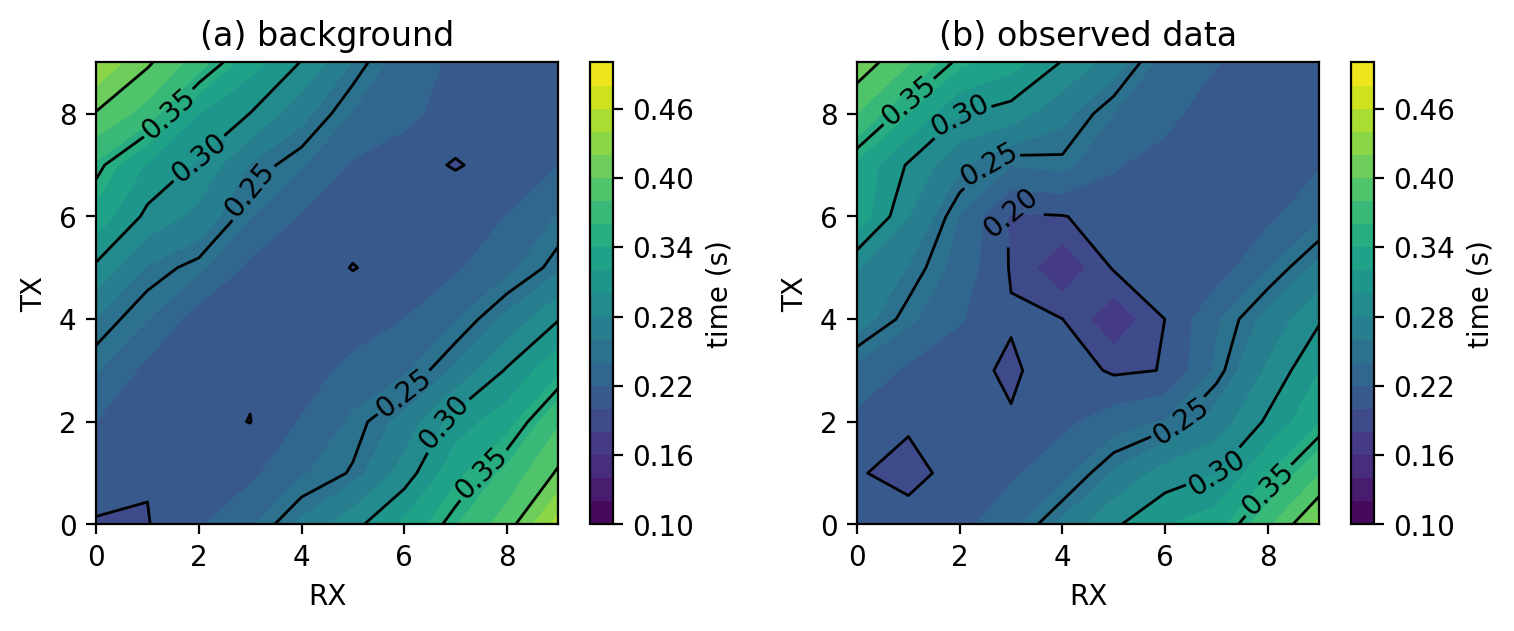

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), dpi=200)

for i, dplot in enumerate([background_noisy_data, noisy_data]): 
    cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))
    
    CS = ax[i].contour(
            dplot.reshape(n_src, n_src, order="F"), 
            levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
    )
    ax[i].clabel(CS, inline=True, fontsize=10)
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

ax[0].set_title("(a) background")
ax[1].set_title("(b) observed data")

## set up the inversion

In [56]:
data_object = data.Data(tomo_survey, dobs=noisy_data, relative_error=relative_error)

In [57]:
src0 = source_list[0]
rx0 = src0.receiver_list[0]
data_object[src0, rx0]

array([0.20649738, 0.2021368 , 0.21566792, 0.23341835, 0.26923987,
       0.28129064, 0.3349014 , 0.33578332, 0.37953882, 0.41374178])

In [58]:
data_object.dobs[:10]

array([0.20649738, 0.2021368 , 0.21566792, 0.23341835, 0.26923987,
       0.28129064, 0.3349014 , 0.33578332, 0.37953882, 0.41374178])

In [59]:
dmis = data_misfit.L2DataMisfit(data_object, simulation)

In [60]:
dmis.W[0, 0]

242.13382100915422

In [61]:
1/data_object.standard_deviation[0]

242.13382100915422

In [62]:
alpha_s = 1e-6 #1/mesh.h[0][0]**2
alpha_x = 1
alpha_y = 1

reg_s = regularization.Smallness(mesh, reference_model=background_slowness_model)
reg_x = regularization.SmoothnessFirstOrder(mesh, orientation="x")
reg_y = regularization.SmoothnessFirstOrder(mesh, orientation="y")

reg = alpha_s * reg_s + alpha_x * reg_x + alpha_y * reg_y

In [63]:
reg2 = regularization.WeightedLeastSquares(
    mesh, 
    alpha_s=alpha_s, 
    alpha_x=alpha_x,
    alpha_y=alpha_y,
    reference_model=background_slowness_model
)

In [64]:
reg2(true_slowness_model)

6.0008e-06

In [65]:
# optimization.InexactGaussNewton

In [66]:
opt = optimization.ProjectedGNCG(lower=0.0, maxIter=30)

invprob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [82]:
chifact = 0.1
beta0_ratio = 1e2
coolingFactor = 1.25

save = directives.SaveOutputDictEveryIteration()
beta_estimate = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
beta_schedule = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=1
)
# target = directives.TargetMisfit(chifact=chifact)

directives_list = [
    beta_estimate,
    beta_schedule,
    save
]

In [83]:
inv = inversion.BaseInversion(invprob, directives_list)

The callback on the ProjectedGNCG Optimization was replaced.


In [84]:
m0 = background_slowness_model
mopt = inv.run(m0)


                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.45e+09  1.08e+03  0.00e+00  1.08e+03    7.39e+04      0              
   1  5.16e+09  5.36e+02  1.35e-08  6.06e+02    6.16e+04      0              
   2  4.13e+09  5.12e+02  1.76e-08  5.85e+02    6.04e+04      0   Skip BFGS  
   3  3.30e+09  4.88e+02  2.28e-08  5.64e+02    5.95e+04      0   Skip BFGS  
   4  2.64e+09  4.64e+02  2.95e-08  5.42e+02    5.85e+04      0   Skip BFGS  
   5  2.11e+09  4.39e+02  3.79e-08  5.19e+02    5.74e+04      0   Skip BFGS  
   6  1.69e+09  4.13e+02  4.87e-08  4.96e+02    5.62e+04      

In [88]:
def plot_tikhonov_curves(beta_values, phi_d, phi_m, phid_star=None, iteration=None, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12,3))
    
    ax[0].plot(beta_values, phi_d)
    ax[1].plot(beta_values, phi_m)
    ax[2].plot(phi_m, phi_d)

    if phid_star is not None: 
        ax[0].plot(beta_values, np.ones_like(beta_values) * phid_star, "--k")
        ax[2].plot(phi_m, np.ones_like(beta_values) * phid_star, "--k")

    ax[0].set_ylabel("$\\phi_d$")
    ax[1].set_ylabel("$\\phi_m$")
    ax[2].set_ylabel("$\\phi_d$")
    ax[2].set_xlabel("$\\phi_m$")
    
    if iteration is not None: 
        ax[0].plot(beta_values[iteration], phi_d[iteration], "C3o")
        ax[1].plot(beta_values[iteration], phi_m[iteration], "C3o")
        ax[2].plot(phi_m[iteration], phi_d[iteration], "C3o")

    for a in ax[:2]:
        a.invert_xaxis()
        a.set_xlabel("$\\beta$")
    plt.tight_layout()
    
    return ax

In [89]:
betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

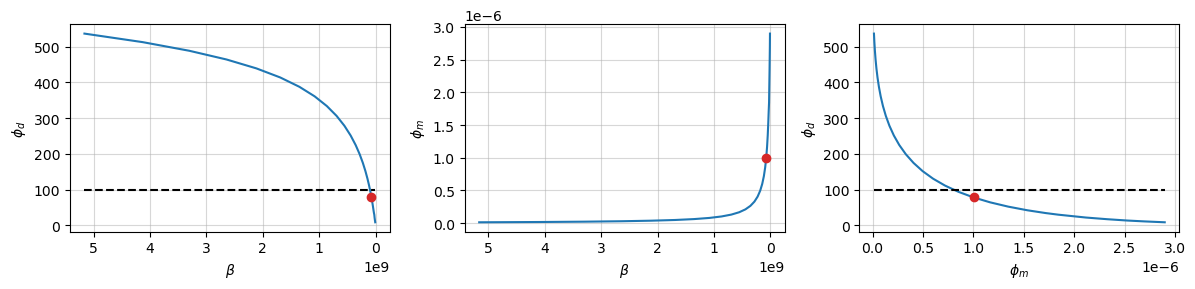

In [96]:
iteration = 19
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<AxesSubplot: xlabel='x', ylabel='y'>

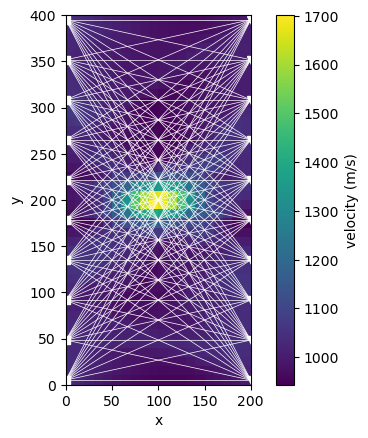

In [97]:
iteration = 19
plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=True,
)

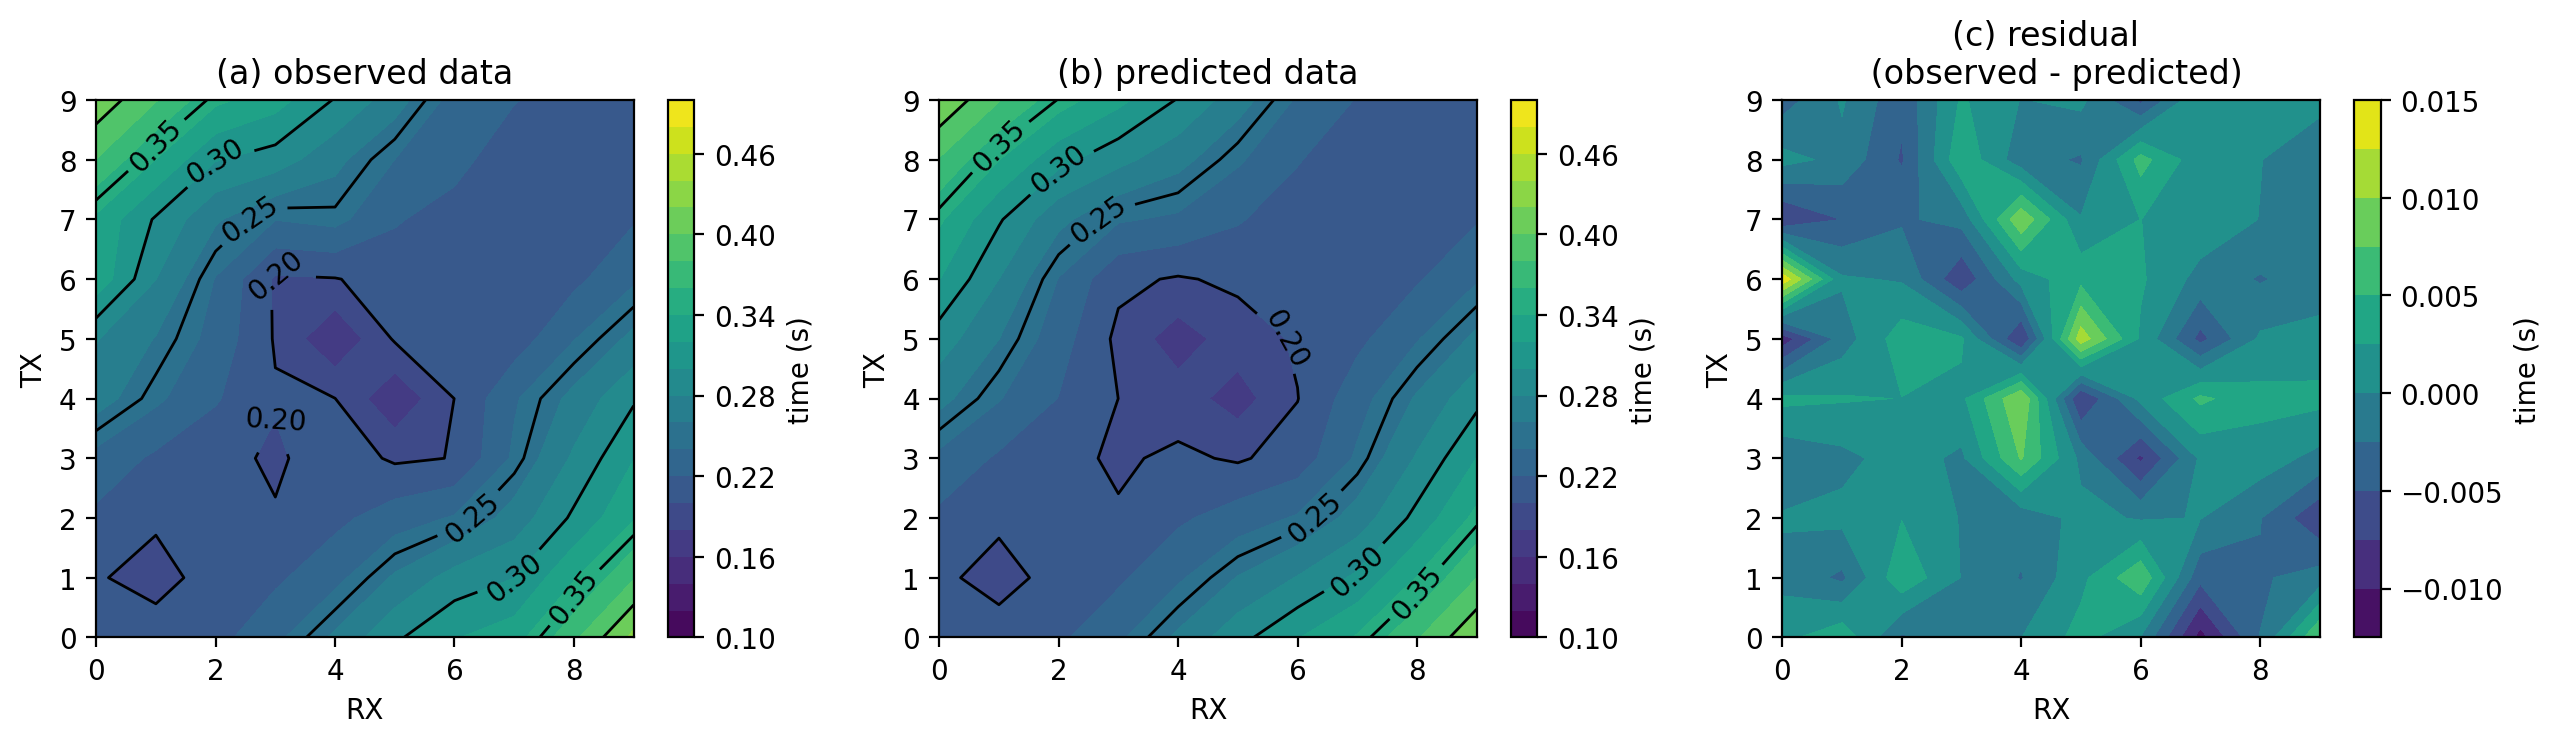

In [98]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.5), dpi=200)
dpred_i = simulation.dpred(models[iteration])

for i, dplot in enumerate([noisy_data, dpred_i, noisy_data-dpred_i]): 
    
    if i < 2: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))

        CS = ax[i].contour(
                dplot.reshape(n_src, n_src, order="F"), 
                levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
        )
        ax[i].clabel(CS, inline=True, fontsize=10)
    else: 
        cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=10))
    
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

ax[0].set_title("(a) observed data")
ax[1].set_title("(b) predicted data")
ax[2].set_title("(c) residual \n (observed - predicted)")
plt.tight_layout()